In [29]:
%matplotlib notebook
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from skimage import measure
from skimage.measure import label
import os.path
from scipy.ndimage.morphology import binary_erosion
import random

In [30]:
working_dir = "../../"

In [60]:
test_file = np.load(working_dir+"1.3.6.1.4.1.14519.5.2.1.6279.6001.100684836163890911914061745866filter.npy")
#mask = np.load(working_dir + "mask.npy")
#lung = np.load(working_dir + "lungs.npy")

In [39]:
def label_size(labeled_matrix, label): return len(labeled_matrix[labeled_matrix==label])
trash_threshold = 0.5
def remove_trash(labeled_matrix,label_num):
    max_label_size = 0
    new_label_num = 0
    for i in range(1,label_num+1):
        if len(labeled_matrix[labeled_matrix == i]) > max_label_size:
            max_label_size = len(labeled_matrix[labeled_matrix == i])
    for i in range(1,label_num+1):
        if label_size(labeled_matrix,i)<trash_threshold*max_label_size:
            labeled_matrix[labeled_matrix == i] = 0
        else:
            new_label_num += 1
            labeled_matrix[labeled_matrix == i] = new_label_num
    return new_label_num

In [40]:
def if_separate(mask):
    mask,count = label(mask, connectivity=1, return_num=True)
    count = remove_trash(mask,count)
    return count != 1

In [41]:
def separate_lungs(label_matrix,layer_num):
    before_morph_open = label_matrix 
    while not if_separate(label_matrix):
        label_matrix = binary_erosion(label_matrix,structure = np.ones((7,1)))
    label_matrix =  label(label_matrix, connectivity=1)
    inverse_erosion(label_matrix, before_morph_open,layer_num)
    return label_matrix

In [42]:
def inverse_erosion(label_matrix, mask,slice_num):
    xs,ys = np.where(label_matrix<mask)
    border_coords = list(zip(xs,ys))
    while len(border_coords):
        to1 = []
        to2 = []
        new_border_coords = []
        for x,y in border_coords:
            chunk = label_matrix[x-1:x+2,y-1:y+2]
            near1 = len(np.where(chunk==1)[0])
            near2 = len(np.where(chunk==2)[0])
            if near1 and near2:
                if slice_num%2:
                    to1.append((x,y))
                else:
                    to2.append((x,y))
            elif near1:
                to1.append((x,y))
            elif len(np.where(chunk==2)[0]):
                to2.append((x,y))
            else:
                new_border_coords.append((x,y))
        if(len(to1)==0 and len(to2)==0):
            return
        for x,y in to1:
            label_matrix[x,y] = 1
        for x,y in to2:
            label_matrix[x,y] = 2
        border_coords = new_border_coords

In [43]:
def separate_new_slice(new_slice,prev_slice,slice_num):
    intersect = new_slice*prev_slice
    inverse_erosion(intersect,new_slice,slice_num)
    return intersect

In [46]:
def separate_lungs3d(file):
    interval = int(file.shape[0]*0.1)
    start_slice_ind= -1
    start_slice = []
    for i in log_progress(range(file.shape[0]//2-interval,file.shape[0]//2+interval)):
        if(if_separate(file[i])):
            start_slice_ind = i
            break
    if(start_slice_ind==-1):
        start_slice = separate_lungs(file[file.shape[0]//2],file.shape[0]//2)
        start_slice_ind = file.shape[0]//2
    else:
        start_slice = label(file[start_slice_ind], connectivity=1)
    print("start_slice_ind = ", start_slice_ind)
    cur_slice = start_slice
    ret = file.astype(int)
    ret[start_slice_ind] = start_slice
    for i in log_progress(range(start_slice_ind+1,file.shape[0])):
        new_slice = separate_new_slice(file[i].astype(int),cur_slice,i)
        ret[i] = new_slice
        cur_slice = new_slice
    cur_slice = start_slice
    for i in log_progress(range(start_slice_ind-1,-1,-1)):
        new_slice = separate_new_slice(file[i].astype(int),cur_slice,i)
        ret[i] = new_slice
        cur_slice = new_slice
    print("expanded to start")
    return ret

In [116]:
sepd = separate_lungs3d(test_file)

start_slice_ind =  220
expanded to start


In [26]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [134]:
def extract_lungs(separated):
    left_lung = separated.copy()
    left_lung[left_lung!=1] = 0
    right_lung = separeted.copy()
    right_lung[right_lung!=2] = 0
    x,y,z = np.where(left_lung)
    left_lung = left_lung[x.min():x.max(),y.min():y.max(),z.min():z.max()]
    x,y,z = np.where(right_lung)
    right_lung = right_lung[x.min():x.max(),y.min():y.max(),z.min():z.max()]
    return left_lung,right_lung

<IPython.core.display.Javascript object>


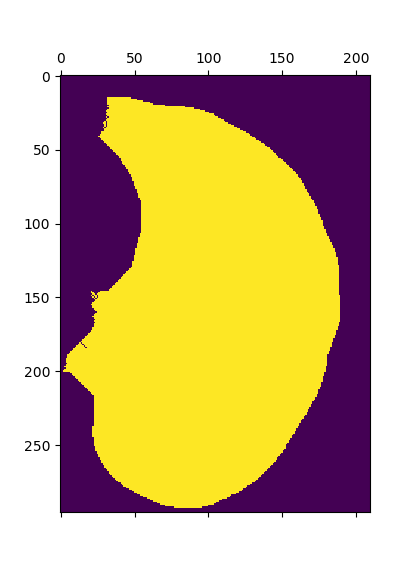

In [136]:
plt.matshow(right_lung[180])